# Skin cancer detection 

### Importing required libraries

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
# from PIL import Image 
import PIL.Image
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D 
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image

import cv2
from IPython.display import display, Image
K.clear_session()

## Loading the dataset

In [3]:
DATASET_PATH = "./dataset"
train_folder = './dataset/train/'

In [4]:
test_folder = './dataset/test/'

In [5]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
 
count_files(os.path.join(test_folder))

There are 360 files in benign
There are 300 files in malignant


## Dataset Summary

In [6]:
print('DATASET SUMMARY')
print('========================\n')
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
print('\n========================')

DATASET SUMMARY

There are 3 directories and 0 images in ./dataset
There are 2 directories and 0 images in ./dataset\data
There are 2 directories and 0 images in ./dataset\data\test
There are 0 directories and 360 images in ./dataset\data\test\benign
There are 0 directories and 300 images in ./dataset\data\test\malignant
There are 2 directories and 0 images in ./dataset\data\train
There are 0 directories and 1440 images in ./dataset\data\train\benign
There are 0 directories and 1197 images in ./dataset\data\train\malignant
There are 2 directories and 0 images in ./dataset\test
There are 0 directories and 360 images in ./dataset\test\benign
There are 0 directories and 300 images in ./dataset\test\malignant
There are 2 directories and 0 images in ./dataset\train
There are 0 directories and 1440 images in ./dataset\train\benign
There are 0 directories and 1197 images in ./dataset\train\malignant



## Visualizing the data (malignant and benign)

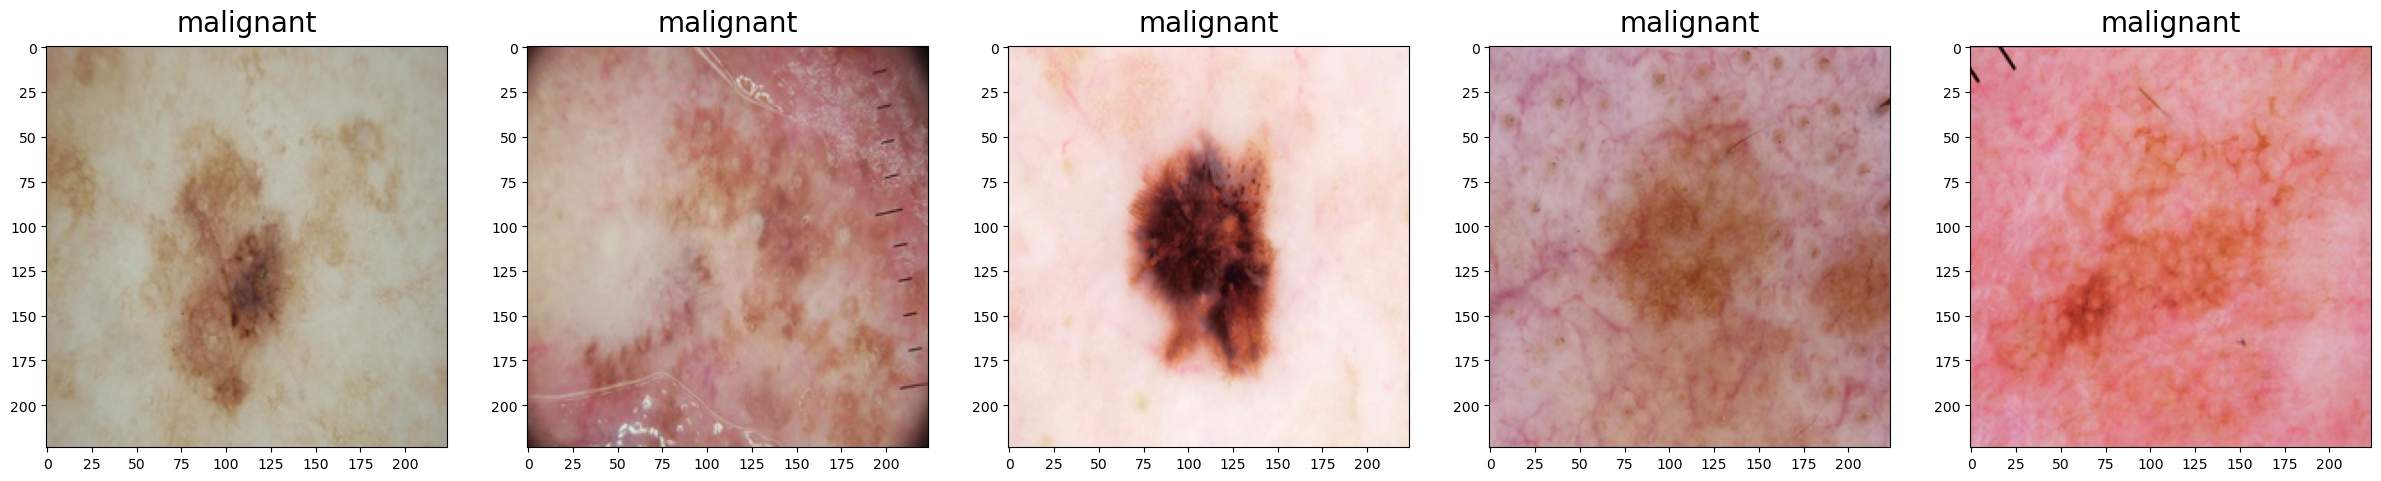

In [7]:
select_folder="malignant"
rows,columns = 1,5

display_folder=os.path.join(train_folder,select_folder)
total_images=rows*columns
fig=plt.figure(1, figsize=(30, 10))

for i,j in enumerate(os.listdir(display_folder)):      
    
    img = plt.imread(os.path.join(train_folder,select_folder,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_folder, pad = 11, size=20)
    plt.imshow(img)
    
    if i==total_images-1:
        break

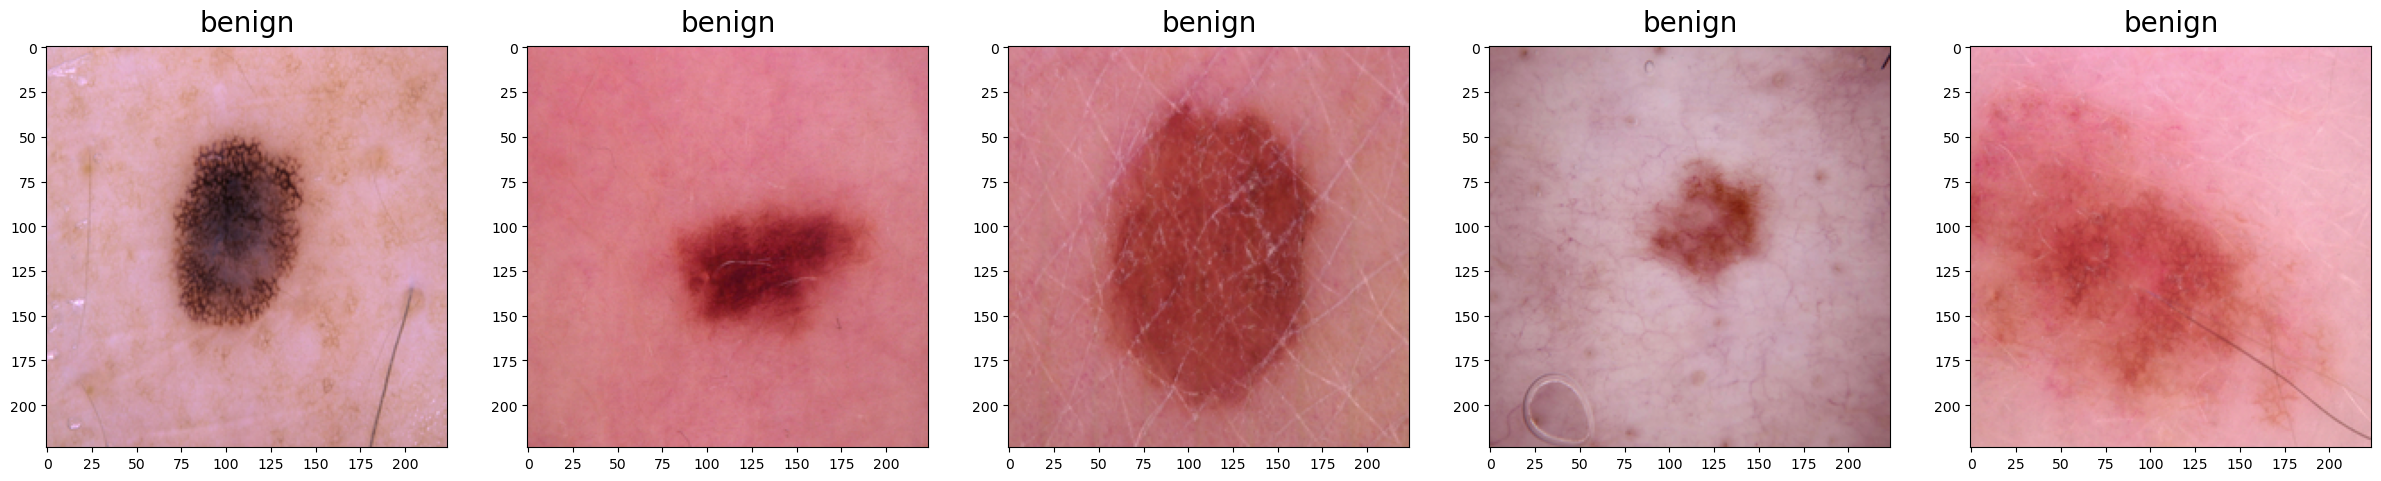

In [8]:
select_folder="benign"
rows,columns = 1,5

display_folder=os.path.join(train_folder,select_folder)
total_images=rows*columns
fig=plt.figure(1, figsize=(30, 10))

for i,j in enumerate(os.listdir(display_folder)):      
    
    img = plt.imread(os.path.join(train_folder,select_folder,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_folder, pad = 11, size=20)
    plt.imshow(img)
    
    if i==total_images-1:
        break

## Preprocessing

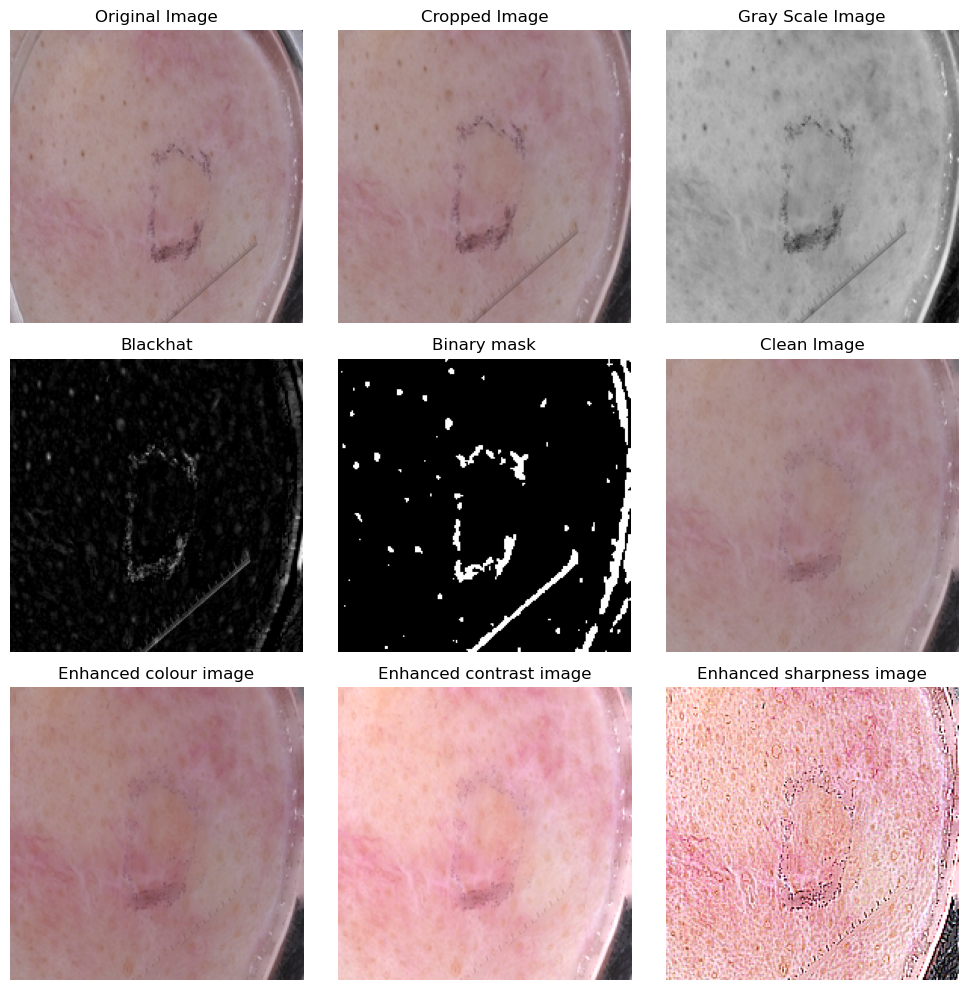

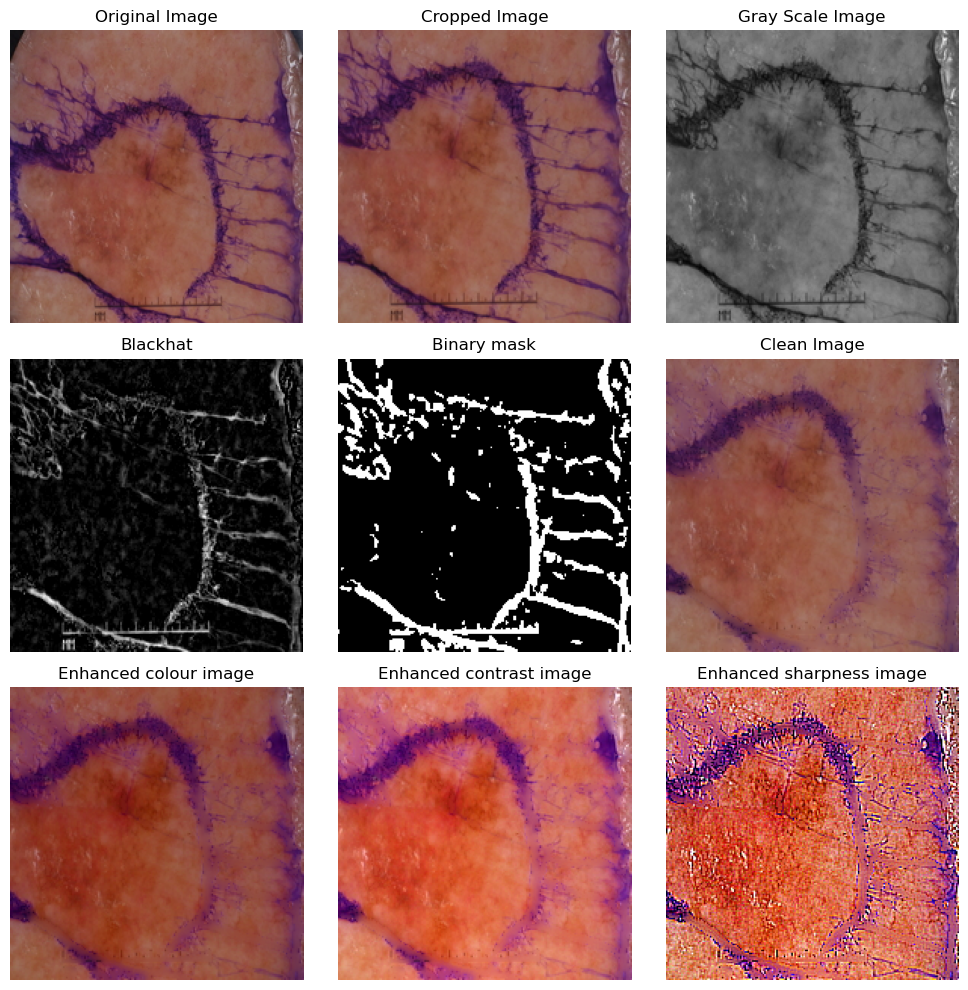

In [9]:
image_folder="malignant"  
number_of_images=2
def Preprocess():
    for i in range(number_of_images):
    
        folder = os.path.join(test_folder,image_folder)
        a=random.choice(os.listdir(folder))
        imgg=cv2.imread(os.path.join(folder,a),cv2.IMREAD_COLOR)
        #Gray scale
        img=imgg[30:410,30:560]
        grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
        #Black hat filter
        kernel = cv2.getStructuringElement(1,(9,9)) 
        blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
        #Gaussian filter
        bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
        #Binary thresholding (MASK)
        ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
        #Replace pixels of the mask
        dst = cv2.inpaint(img,mask,6,cv2.INPAINT_TELEA)

        plt.figure(figsize=(10, 10))

        # Original image
        plt.subplot(3, 3, 1)
        plt.imshow(cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        # Cropped image
        plt.subplot(3, 3, 2)
        
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Cropped Image')
        plt.axis('off')

        # Gray Scale image
        plt.subplot(3, 3, 3)
        plt.imshow(grayScale, cmap='gray')
        plt.title('Gray Scale Image')
        plt.axis('off')

        plt.subplot(3, 3, 4)
        plt.imshow(blackhat, cmap='gray')
        plt.title("Blackhat")
        plt.axis('off')

        plt.subplot(3, 3, 5)
        plt.imshow(mask, cmap='gray')
        plt.title("Binary mask")
        plt.axis('off')

        # Clean image
        plt.subplot(3, 3, 6)
        plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
        plt.title('Clean Image')
        plt.axis('off')

        # Colour enhance
        hsv_image = cv2.cvtColor(dst, cv2.COLOR_BGR2HSV)
        hsv_image[..., 1] = cv2.multiply(hsv_image[..., 1], 1.35)
        enhanced_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
        plt.subplot(3, 3, 7)
        plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
        plt.title('Enhanced colour image')
        plt.axis('off')


        # Enhance contrast
        enhanced_image = cv2.convertScaleAbs(enhanced_image, alpha=1.45, beta=0)
        plt.subplot(3, 3, 8)
        plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
        plt.title('Enhanced contrast image')
        plt.axis('off')

        # Enhance sharpness
        enhanced_image = cv2.filter2D(enhanced_image, -1, kernel=np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
        plt.subplot(3, 3, 9)
        plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
        plt.title('Enhanced sharpness image')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        print("")
        print("")
    
Preprocess()

## Visualize test and train dataset

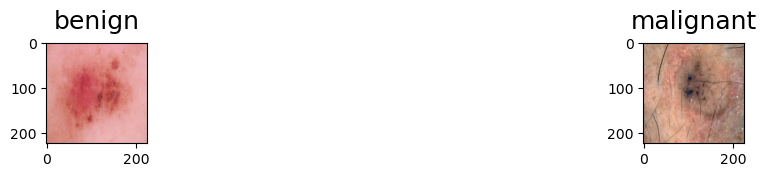

In [10]:
images = []

for image_folder in sorted(os.listdir(train_folder)):
    leaf = os.listdir(train_folder + '/' + image_folder)
    img_selected = np.random.choice(leaf)
    images.append(os.path.join(train_folder,image_folder,img_selected))
                                     
fig=plt.figure(1, figsize=(30, 10))

for subplot,image_ in enumerate(images):
    cat=image_.split('\\')[-2]
    category=cat.split('/')[-1]
#     category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(7, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

## Modelling

In [11]:
n_cat =2

batch_size = 48
batch_size_predict = 128
input_shape = (299,299)

In [12]:
x_model = Xception(input_shape=list(input_shape) + [3], 
                   weights='imagenet', 
                   include_top=False)

In [13]:
for layer in x_model.layers:
    layer.trainable = True

for layer in x_model.layers[:85]:
    layer.trainable = False   
    
x_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

                                                                                                  
 block4_sepconv2_act (Activ  (None, 37, 37, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 37, 37, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 37, 37, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_2 

                                                                                                  
 block7_sepconv1 (Separable  (None, 19, 19, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 19, 19, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 19, 19, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, 19, 19, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, 19, 19, 728)          0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 19, 19, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, 19, 19, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 19, 19, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 19, 19, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, 19, 19, 728)          0         ['block12_sepconv3_bn[0][0]', 
          

In [14]:
gm_exp = tf.Variable(3., dtype=tf.float32)
def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                           axis=[1,2], 
                           keepdims=False)+1.e-8)**(1./gm_exp)
    return pool

In [15]:
X_feat = Input(x_model.output_shape[1:])

lambda_layer = Lambda(generalized_mean_pool_2d)
lambda_layer.trainable_weights.extend([gm_exp])
X = lambda_layer(X_feat)
X = Dropout(0.05)(X)
X = Activation('relu')(X)
X = Dense(n_cat, activation='softmax')(X)

top_model = Model(inputs=X_feat, outputs=X)
top_model.summary()

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 10, 2048)]    0         
                                                                 
 lambda (Lambda)             (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 activation (Activation)     (None, 2048)              0         
                                

In [16]:
X_image = Input(list(input_shape) + [3])

X_f = x_model(X_image)
X_f = top_model(X_f)

model = Model(inputs=X_image, outputs=X_f)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 model (Functional)          (None, 2)                 4098      
                                                                 
Total params: 20865578 (79.60 MB)
Trainable params: 11634410 (44.38 MB)
Non-trainable params: 9231168 (35.21 MB)
_________________________________________________________________


In [17]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [18]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (299, 299),
    batch_size = 48,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (299, 299),
    batch_size = 48, 
    class_mode = 'categorical')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [19]:
class_map = training_set.class_indices
class_map

{'benign': 0, 'malignant': 1}

In [20]:
Model = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
)

55/55 [==============================] - 758s 14s/step - loss: 0.4488 - accuracy: 0.7929 - val_loss: 2.0077 - val_accuracy: 0.6652


In [21]:
score = model.evaluate_generator(test_set)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.007667303085327
Test accuracy: 0.6651515364646912


In [22]:
validation_data_dir = './dataset/test/'

validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(299,299),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 660 images belonging to 2 classes.
Test Accuracy: 0.665


## Prediction using our model

In [23]:
category={
    0:'benign',1:'malignant'
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(299, 299))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Actual  - Malignant\nPrediction - {}".format(category[index]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(299, 299))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

1/1 [==============================] - 1s 1s/step


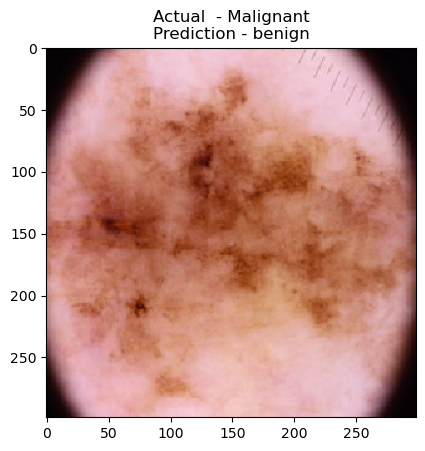

In [24]:
predict_image(os.path.join(validation_data_dir,'malignant/1026.jpg'),model)

1/1 [==============================] - 0s 289ms/step


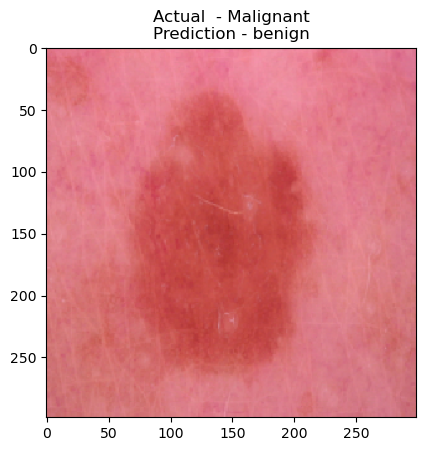

In [25]:
predict_image(os.path.join(validation_data_dir,'benign/1042.jpg'),model)

## Confusion matrix

In [26]:
def labels_confusion_matrix(test_folder):
    
    folder_path=test_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(299,299))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 2
    cmap="OrRd"
    cm_plot_labels = [i for i in range(2)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) 
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) 

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

1/1 [==============================] - 0s 222ms/step


1/1 [==============================] - 0s 208ms/step


1/1 [==============================] - 0s 220ms/step


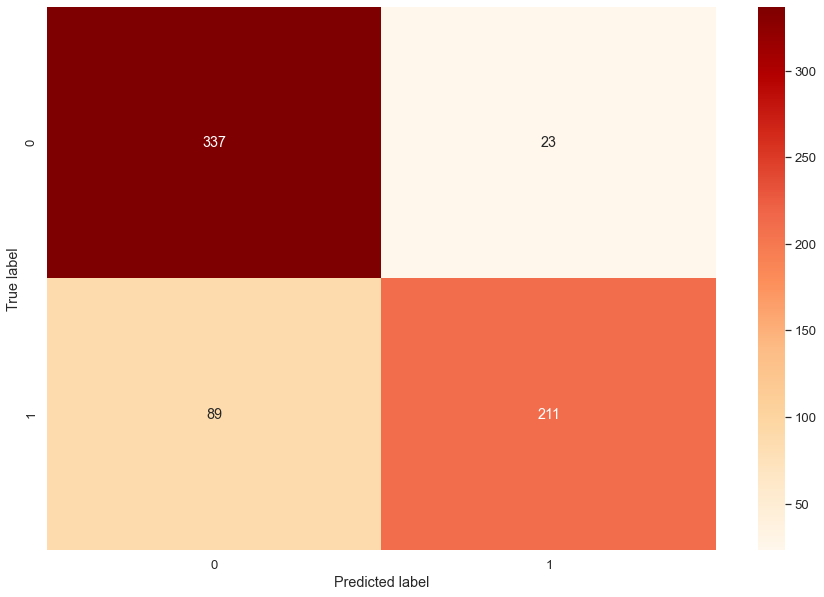

In [27]:
y_true,y_pred=labels_confusion_matrix(test_folder)
print_confusion_matrix(y_true,y_pred)